# New libraries to install

In [1]:
%pip install pyod

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Connection to drive and path definition

In [2]:
import sys
sys.path.insert(0, '/home/gpaasch/ml4nce')
path_files ='/home/gpaasch/ml4nce/UC2/'

# Import libraries

In [3]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
from SANDS import sands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy


from pyod.models.lof import LOF
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


2024-05-24 20:21:37.231113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 20:21:37.832354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data generation

Run the next four cells if you want to generate new data, otherwise skip them and load from the saved file

In [4]:
parameters1 = {
        'time_delta':5
    }

In [5]:
device_filter = {
    'vendor':'Versa'
}

In [6]:
metric_df = sands.generate_device_metric_time_range(datetime.now(),datetime.now()+timedelta(minutes=4),parameters1,"none",['mem_utilization','cpu_utilization'],device_filter)


In [7]:
metric_df.to_csv(join(path_files,'mem_and_cpu_utilization_sdwan_metric.csv'))

In [8]:
metric_df

,timestamp,cpu_utilization,device_name,vendor,model,os,version,hw_revision,role,ip_address,mem_utilization
0,1716582099,NaN,E-1-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.1,32.0
1,1716582099,34,E-1-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.1,NaN
2,1716582099,NaN,E-1-2,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.2,34.0
3,1716582099,34,E-1-2,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.2,NaN
4,1716582099,NaN,E-2-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_branch,10.3.2.1,30.0
...,...,...,...,...,...,...,...,...,...,...,...
395,1716582099,10,E-99-2,Versa,versa_2,VOS,21.1.1,hw-versa-0001,vedge_branch,10.3.99.2,NaN
396,1716582099,NaN,E-100-1,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.1,76.0
397,1716582099,32,E-100-1,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.1,NaN
398,1716582099,NaN,E-100-2,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.2,77.0


# Data preparation

In [9]:
metric_df = metric_df.fillna(0)

In [10]:
metric_df

,timestamp,cpu_utilization,device_name,vendor,model,os,version,hw_revision,role,ip_address,mem_utilization
0,1716582099,0,E-1-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.1,32.0
1,1716582099,34,E-1-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.1,0.0
2,1716582099,0,E-1-2,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.2,34.0
3,1716582099,34,E-1-2,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_hub,10.3.1.2,0.0
4,1716582099,0,E-2-1,Versa,versa_1,VOS,21.1.0,hw-versa-0001,vedge_branch,10.3.2.1,30.0
...,...,...,...,...,...,...,...,...,...,...,...
395,1716582099,10,E-99-2,Versa,versa_2,VOS,21.1.1,hw-versa-0001,vedge_branch,10.3.99.2,0.0
396,1716582099,0,E-100-1,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.1,76.0
397,1716582099,32,E-100-1,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.1,0.0
398,1716582099,0,E-100-2,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.2,77.0


In [11]:
new_metric_df = metric_df.groupby('device_name').sum(['cpu_utilization','memory_utilization'])

In [12]:
new_metric_df

,timestamp,cpu_utilization,mem_utilization
device_name,,,
E-1-1,3433164198,34,32.0
E-1-2,3433164198,34,34.0
E-10-1,3433164198,32,30.0
E-10-2,3433164198,34,33.0
E-100-1,3433164198,32,76.0
...,...,...,...
E-97-2,3433164198,80,34.0
E-98-1,3433164198,11,33.0
E-98-2,3433164198,10,34.0


In [13]:
new_metric_df.drop(columns=['timestamp'],inplace=True)

In [14]:
new_metric_df

,cpu_utilization,mem_utilization
device_name,,
E-1-1,34,32.0
E-1-2,34,34.0
E-10-1,32,30.0
E-10-2,34,33.0
E-100-1,32,76.0
...,...,...
E-97-2,80,34.0
E-98-1,11,33.0
E-98-2,10,34.0


timestamp is not relevant in this use case, we will focus on the memory utilization column, and the device_name columns. All other columns will be ignored for the moment.

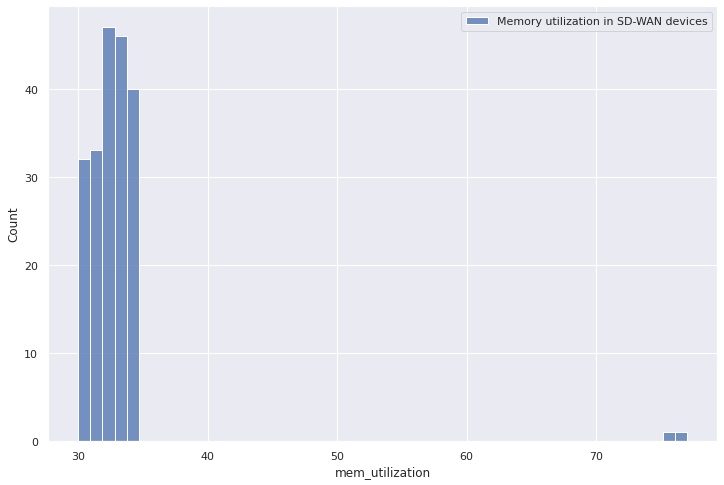

In [15]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=new_metric_df,x='mem_utilization', bins=50)
plt.legend(['Memory utilization in SD-WAN devices'])

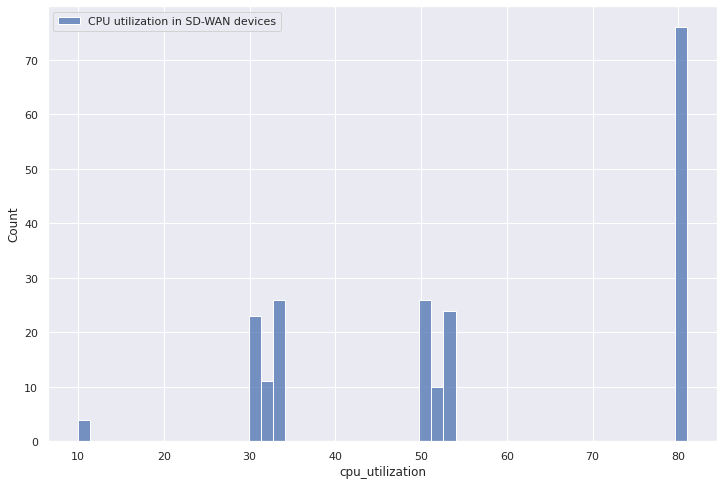

In [16]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=new_metric_df,x='cpu_utilization', bins=50)
plt.legend(['CPU utilization in SD-WAN devices'])

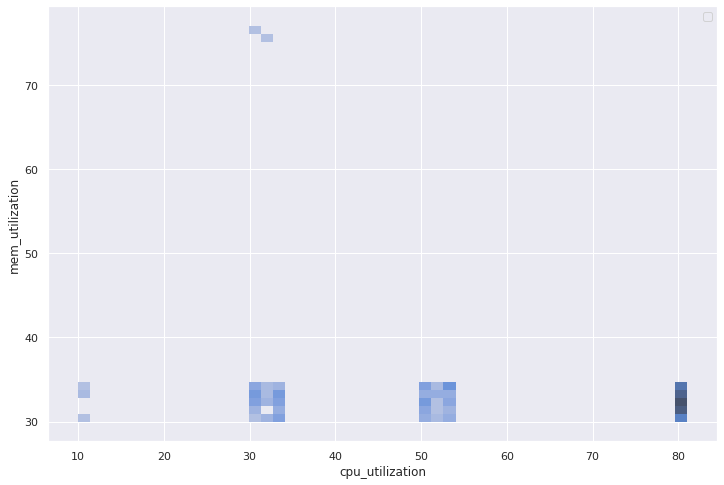

In [17]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization', bins=50)
plt.legend(['CPU and memory utilization in SD-WAN devices'])

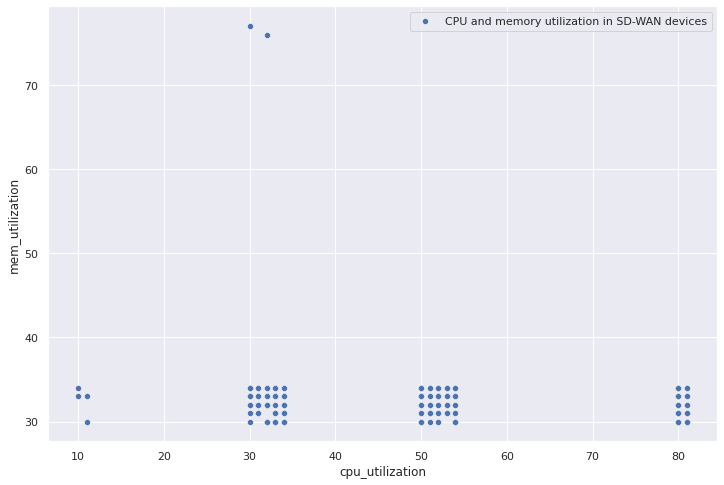

In [18]:
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization')
plt.legend(['CPU and memory utilization in SD-WAN devices'])

# Local Outlier Factor

In [19]:
X_train = new_metric_df[['mem_utilization','cpu_utilization']].values
X_test = X_train

In [20]:
lof = LOF(contamination=0.05)


In [21]:
lof = LOF(contamination=0.03) 
lof.fit(X_train)

y_train_scores = lof.decision_function(X_train)
y_train_pred = lof.predict(X_train)

y_test_scores = lof.decision_function(X_test)
y_test_pred = lof.predict(X_test) # outlier labels (0 or 1)

def count_stat(vector):
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The threshold for the defined contamination rate:" , lof.threshold_)

The training data: {0: 194, 1: 6}
The threshold for the defined contamination rate: 1.4375313659065139


In [22]:
y_test_scores

array([ 0.97166158,  1.04407165,  1.06647751,  0.99653169, 18.93990496,
       19.48906065,  0.953978  ,  1.03768997,  0.9829701 ,  1.02773092,
        1.02446274,  0.98944612,  0.99731475,  1.04177964,  1.01056903,
        1.01056903,  1.0006459 ,  1.0006459 ,  0.99731475,  1.05734069,
        1.0006459 ,  0.9829701 ,  0.99653169,  1.02773092,  1.0446932 ,
        1.02446274,  0.99653169,  1.03768997,  0.9829701 ,  1.03082578,
        1.02818151,  0.99653169,  1.03082578,  0.9829701 ,  0.896881  ,
        0.97166158,  1.01881587,  1.0446932 ,  1.0006459 ,  1.0446932 ,
        1.02818151,  1.05734069,  0.95071022,  1.21125056,  1.0067237 ,
        0.97166158,  1.03082578,  0.97166158,  1.0187677 ,  1.0339809 ,
        0.96967148,  1.10833702,  1.00845232,  0.9894533 ,  1.01605655,
        0.9894533 ,  1.04859644,  0.95997063,  0.96967148,  1.06643469,
        1.19075698,  0.9894533 ,  0.96647749,  0.98270483,  0.99653666,
        0.93087159,  1.04859644,  1.05975626,  1.0067237 ,  0.95

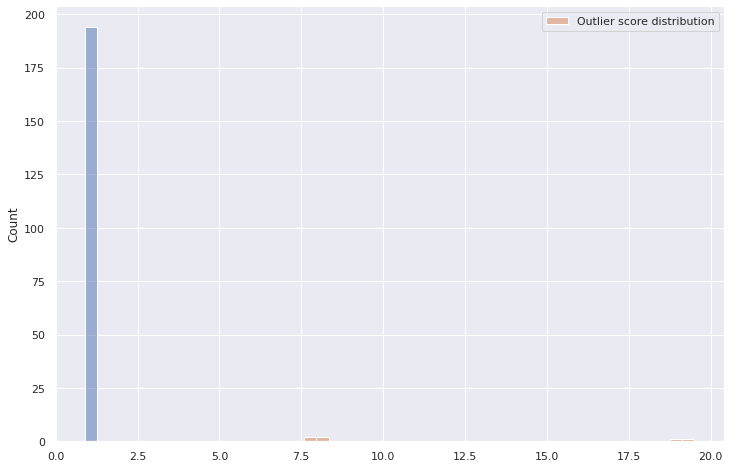

In [23]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(x=y_test_scores, bins=50,hue=y_test_pred)
plt.legend(['Outlier score distribution'])

In [24]:
print('Outlier list:')
print(new_metric_df.iloc[y_test_pred==1,:])

Outlier list:
             cpu_utilization  mem_utilization
device_name                                  
E-100-1                   32             76.0
E-100-2                   30             77.0
E-98-1                    11             33.0
E-98-2                    10             34.0
E-99-1                    11             30.0
E-99-2                    10             33.0


In [25]:
new_metric_df['outlier']=0
new_metric_df.iloc[y_test_pred==1,new_metric_df.columns.get_loc('outlier')]=1

In [26]:
new_metric_df

,cpu_utilization,mem_utilization,outlier
device_name,,,
E-1-1,34,32.0,0
E-1-2,34,34.0,0
E-10-1,32,30.0,0
E-10-2,34,33.0,0
E-100-1,32,76.0,1
...,...,...,...
E-97-2,80,34.0,0
E-98-1,11,33.0,1
E-98-2,10,34.0,1


Text(0.5, 1.0, 'CPU and memory utilization outliers in SD-WAN devices')

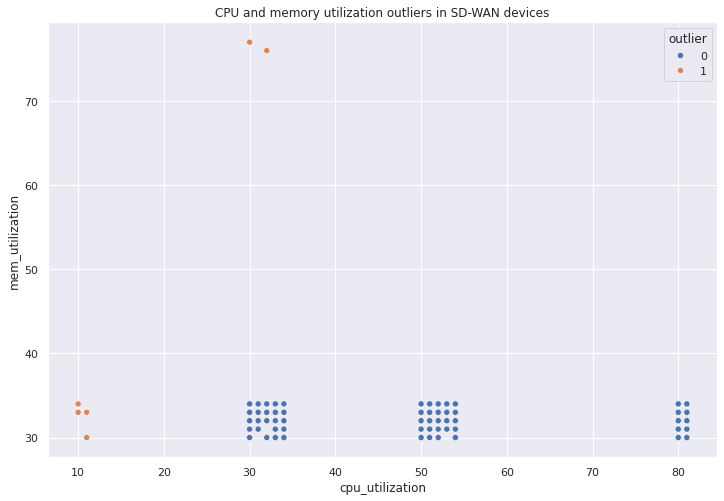

In [27]:
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization',hue='outlier')
plt.title('CPU and memory utilization outliers in SD-WAN devices')

# Isolation Forest

In [28]:
iforest = IsolationForest(n_estimators = 100, contamination = 0.03)
y_pred = iforest.fit_predict(X_train)
y_pred[y_pred == -1]=0

In [29]:
print("Number of outliers detected: {}".format(y_pred[y_pred == 0].shape[0]))
print("Number of normal samples detected: {}".format(y_pred[y_pred > 0].sum()))

Number of outliers detected: 6
Number of normal samples detected: 194


In [30]:
new_metric_df['outlier_isoforest']=y_pred

Text(0.5, 1.0, 'CPU and memory utilization outliers detected by Isolation Forest in SD-WAN devices')

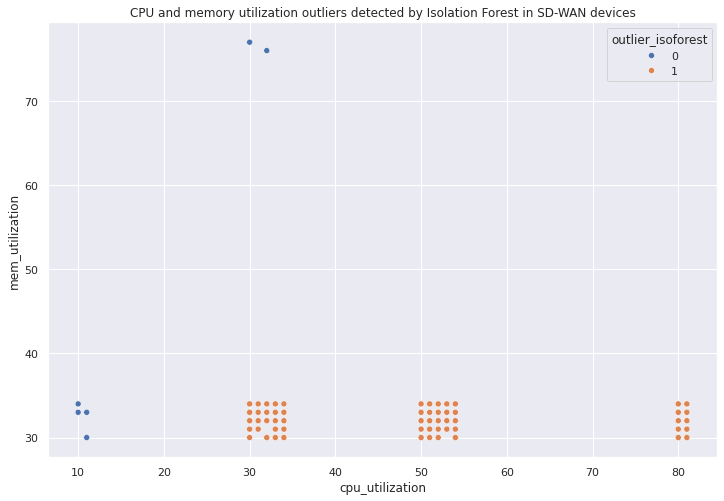

In [31]:
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization',hue='outlier_isoforest')
plt.title('CPU and memory utilization outliers detected by Isolation Forest in SD-WAN devices')

In [32]:
X_train.shape

(200, 2)

# DBSCAN

In [33]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)

In [34]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_train_scaled)
distances, indices = nbrs.kneighbors(X_train_scaled)

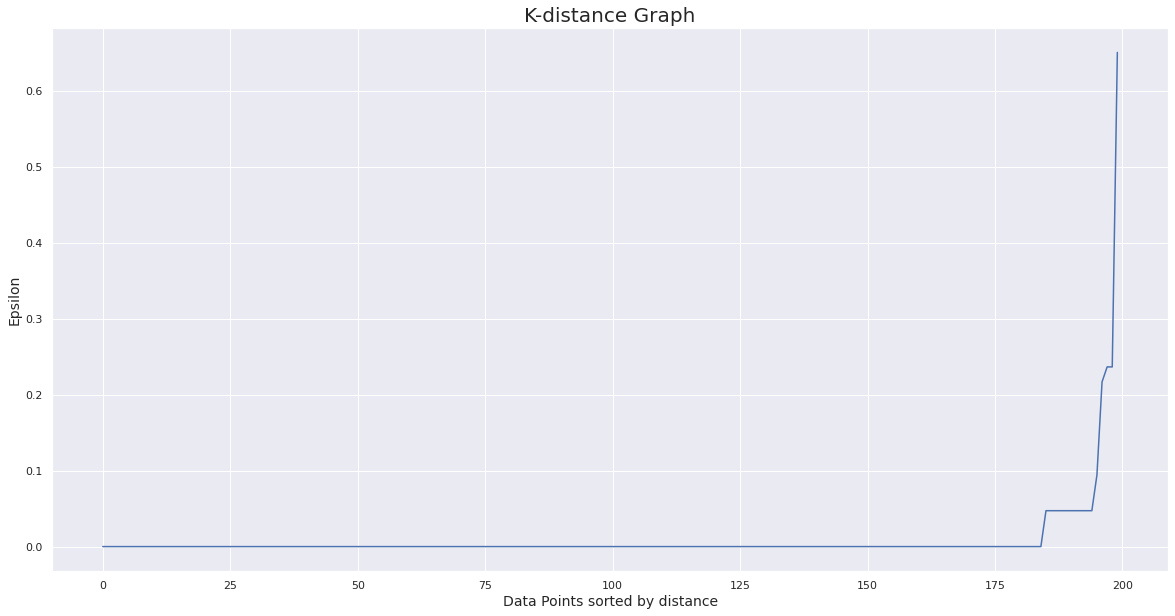

In [35]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [36]:
dbscan=DBSCAN(eps=0.4,min_samples=10)
dbscan.fit(X_train_scaled)

DBSCAN(eps=0.4, min_samples=10)

In [37]:
dbscan.labels_

array([ 0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  0,  0,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2, -1, -1, -1, -1])

Text(0.5, 1.0, 'CPU and memory utilization outliers with DBSCAN in SD-WAN devices')

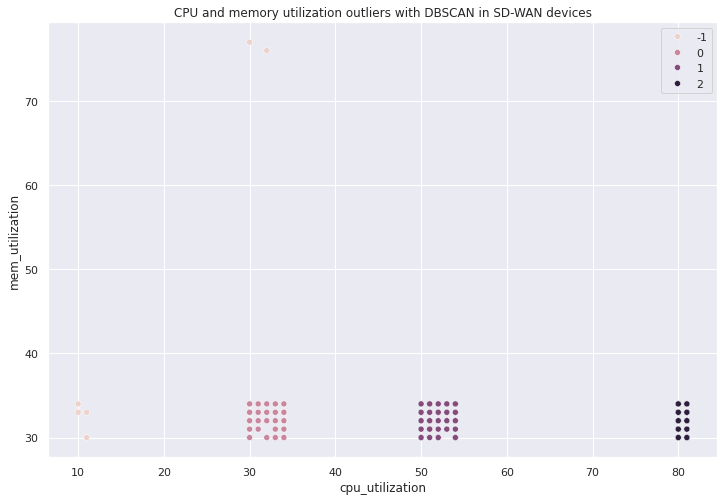

In [38]:
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization',hue=dbscan.labels_)
plt.title('CPU and memory utilization outliers with DBSCAN in SD-WAN devices')

In [39]:
dbscan_outliers = np.zeros(X_train.shape[0])
dbscan_outliers[dbscan.labels_<0]=1

In [40]:
new_metric_df['outlier_dbscan']=dbscan_outliers

In [41]:
new_metric_df

,cpu_utilization,mem_utilization,outlier,outlier_isoforest,outlier_dbscan
device_name,,,,,
E-1-1,34,32.0,0,1,0.0
E-1-2,34,34.0,0,1,0.0
E-10-1,32,30.0,0,1,0.0
E-10-2,34,33.0,0,1,0.0
E-100-1,32,76.0,1,0,1.0
...,...,...,...,...,...
E-97-2,80,34.0,0,1,0.0
E-98-1,11,33.0,1,0,1.0
E-98-2,10,34.0,1,0,1.0


Text(0.5, 1.0, 'CPU and memory utilization outliers detected by DBSCAN in SD-WAN devices')

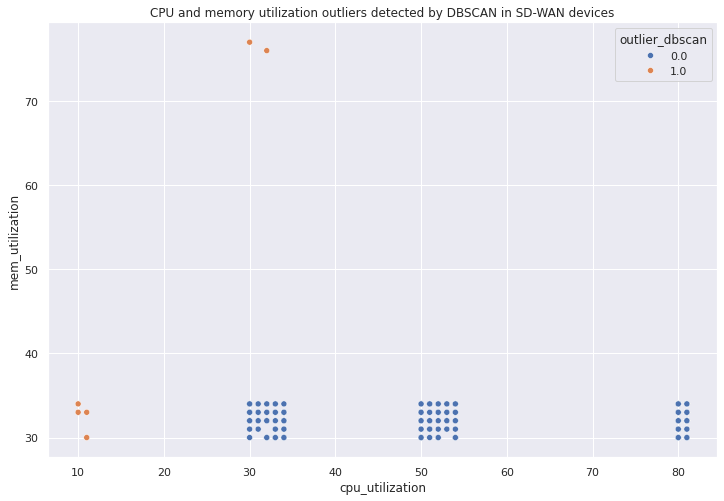

In [42]:
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization',hue='outlier_dbscan')
plt.title('CPU and memory utilization outliers detected by DBSCAN in SD-WAN devices')